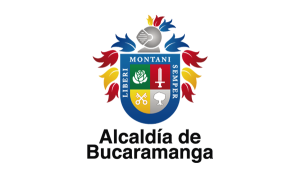

## Secretaría de Salud y Ambiente
---







<a href="https://colab.research.google.com/github/JotaRodriguez94/Forecasting_COVID_BGA/blob/main/EDA_COVID_19_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

## Exploración y análisis de las series temporales relacionadas con COVID-19

In [2]:
#@title Importar dependencias
# Uncomment this block to install necessary dependencies.
#!pip install statsmodels
# download the code
!git clone https://github.com/JotaRodriguez94/Forecasting_COVID_BGA.git
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
from Forecasting_COVID_BGA import utils
from collections import defaultdict
import datetime
#importlib.reload(utils);

seed = 7
plt.style.use('ggplot')
np.random.seed(seed=seed)

Cloning into 'Forecasting_COVID_BGA'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 205 (delta 84), reused 80 (delta 24), pack-reused 0
Receiving objects: 100% (205/205), 14.80 MiB | 5.56 MiB/s, done.
Resolving deltas: 100% (84/84), done.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#@title Descargar los datos y procesarlos
!wget -q https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv -O Casos_positivos_de_COVID-19_en_Colombia.csv
data_colombia = pd.read_csv('/content/Casos_positivos_de_COVID-19_en_Colombia.csv')
!wget -q https://covid.ourworldindata.org/data/owid-covid-data.xlsx -O owid-covid-data.xlsx  
data = pd.read_excel('/content/owid-covid-data.xlsx')
# preproccesing data
# preproccesing data
df_join = utils.preproccesing_data(data, data_colombia, 'Fecha de inicio de síntomas')

Max value in days 335


In [5]:
#@title Seleccionar los países, ciudades y departamentos a usar
# select the countries. cities and deps
countries_top = ['Argentina', 'Bangladesh', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Czech Republic',
'France', 'Germany', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Italy', 'Mexico',
'Morocco', 'Netherlands', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Romania',
'Russia', 'Saudi Arabia', 'South Africa', 'Spain', 'Turkey', 'Ukraine', 'United Kingdom',
'United States']
dep_top = ['ANTIOQUIA', 'ATLANTICO', 'CUNDINAMARCA', 'SANTANDER', 'VALLE']
cities_top = ['BARRANQUILLA', 'BOGOTA', 'BUCARAMANGA', 'CALI', 'CARTAGENA', 'MEDELLIN']

series = cities_top + dep_top + countries_top
df_join = df_join[series]
df_join

,BARRANQUILLA,BOGOTA,BUCARAMANGA,CALI,CARTAGENA,MEDELLIN,ANTIOQUIA,ATLANTICO,CUNDINAMARCA,SANTANDER,VALLE,Argentina,Bangladesh,Belgium,Brazil,Canada,Chile,Czech Republic,France,Germany,India,Indonesia,Iran,Iraq,Israel,Italy,Mexico,Morocco,Netherlands,Pakistan,Peru,Philippines,Poland,Romania,Russia,Saudi Arabia,South Africa,Spain,Turkey,Ukraine,United Kingdom,United States
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2.0,1.0,2.0,16.0,4.0,6.0,8.0,31.0,7.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,2.0,1.0,2.0,16.0,4.0,6.0,8.0,31.0,7.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,2.0,1.0,2.0,16.0,4.0,6.0,8.0,31.0,7.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,2.0,1.0,2.0,16.0,4.0,6.0,8.0,31.0,7.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,2.0,1.0,2.0,16.0,4.0,6.0,8.0,31.0,7.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-27,10.0,34.0,4.0,11.0,14.0,28.0,63.0,31.0,17.0,26.0,26.0,9043.0,2292.0,2565.0,37614.0,5679.0,1570.0,6305.0,13663.0,21951.0,43082.0,5828.0,13961.0,2483.0,1169.0,29001.0,8107.0,4178.0,4605.0,3045.0,0.0,1382.0,16690.0,8499.0,25195.0,322.0,3069.0,12289.0,36008.0,16494.0,17557.0,110611.0
2020-11-28,1.0,13.0,1.0,19.0,4.0,5.0,16.0,2.0,13.0,3.0,2.0,7846.0,2273.0,3297.0,34130.0,5954.0,1581.0,4464.0,12672.0,20819.0,41322.0,5418.0,14051.0,2545.0,718.0,28342.0,0.0,4592.0,5883.0,2829.0,3908.0,1621.0,17304.0,8134.0,27267.0,302.0,3370.0,10853.0,44506.0,16585.0,14821.0,205557.0
2020-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6098.0,1908.0,3619.0,51922.0,5675.0,1698.0,2665.0,12580.0,13845.0,41810.0,6267.0,13402.0,1606.0,987.0,26315.0,22809.0,4412.0,4594.0,2839.0,4021.0,1879.0,15177.0,5554.0,26809.0,220.0,3198.0,0.0,30103.0,13271.0,15891.0,155596.0


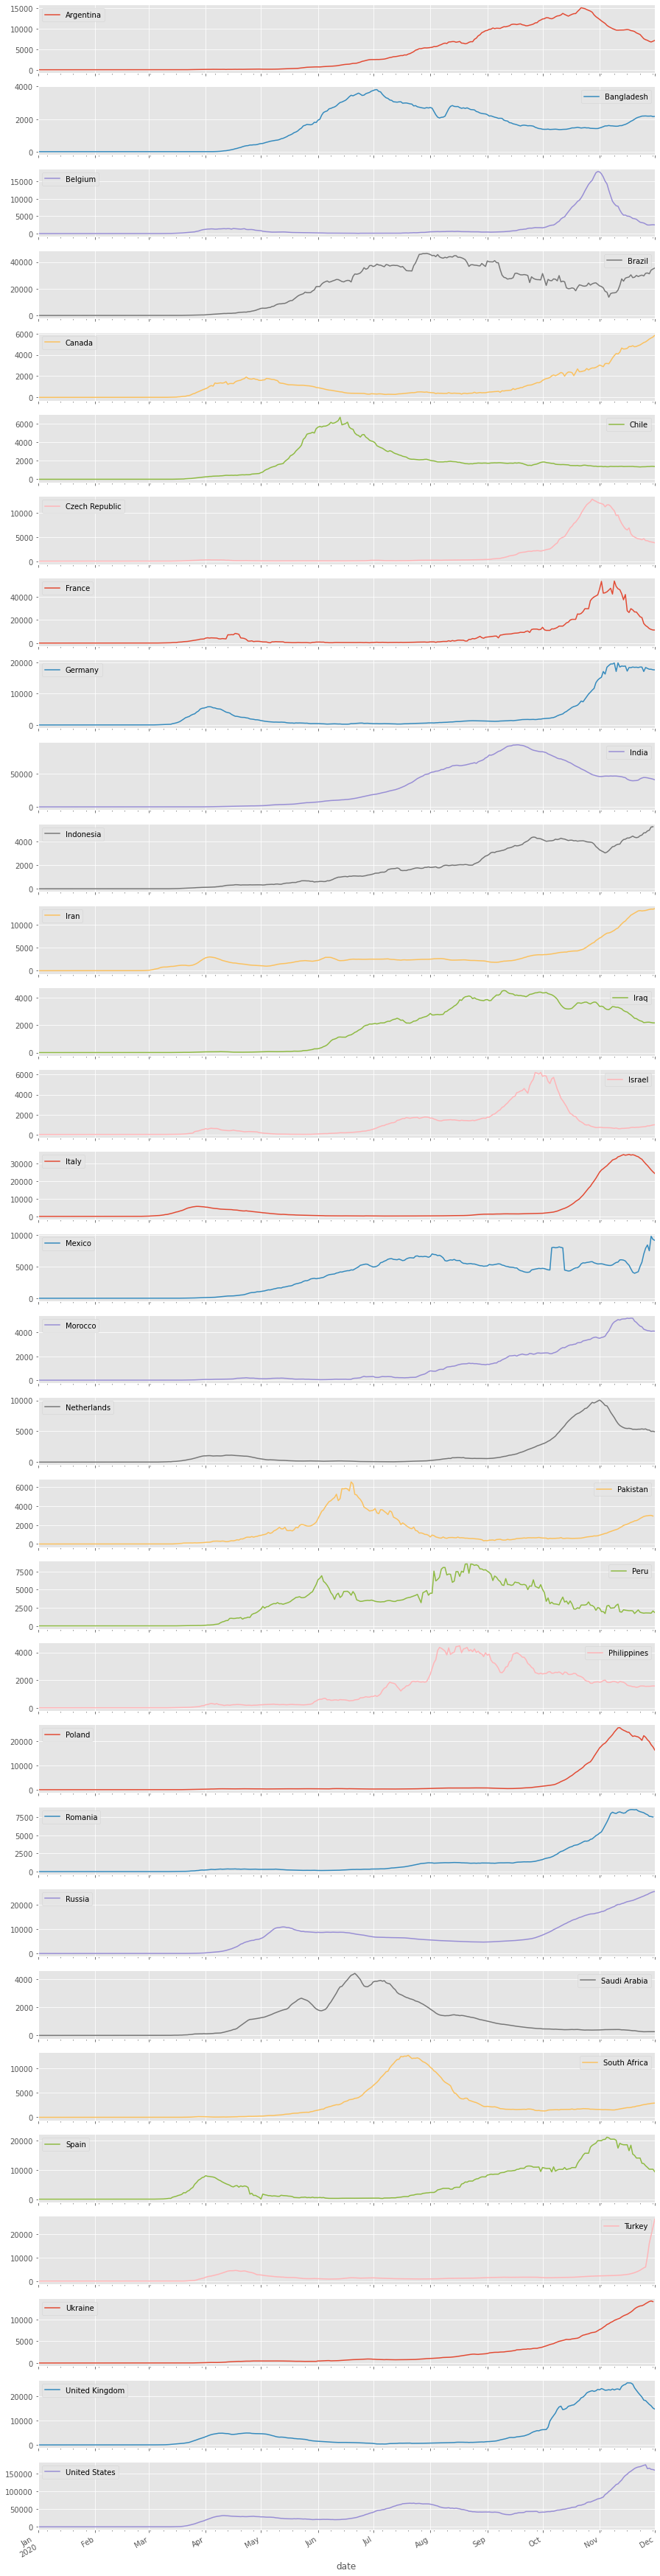

In [6]:
#@title Visualización países - Suavizado semanal
df_join[countries_top].iloc[:, :].rolling(7).mean().fillna(
    axis=0, method='backfill', inplace=False).plot(subplots=True,
                                                   figsize=(15, 70));

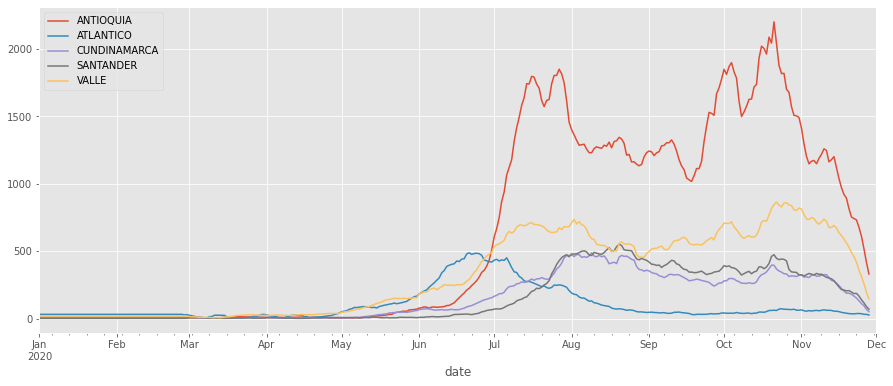

In [7]:
#@title Visualización Departamentos - Suavizado semanal
df_join[dep_top].iloc[:, :].rolling(7).mean().fillna(
    axis=0, method='backfill', inplace=False).plot(subplots=False,
                                                   figsize=(15, 6));

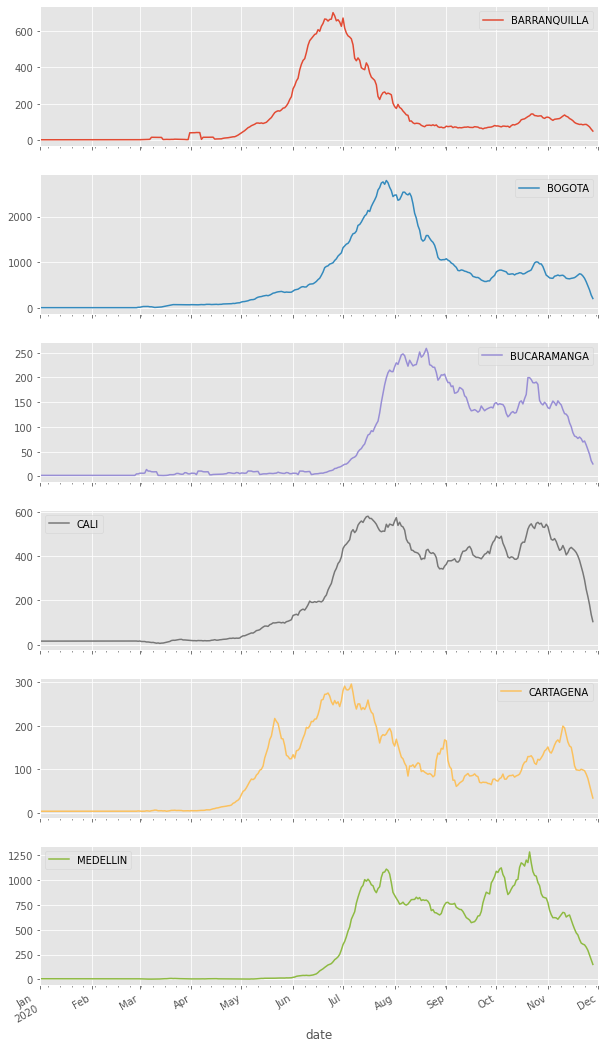

In [8]:
#@title Visualización Ciudades - Suavizado semanal
df_join[cities_top].iloc[:, :].rolling(7).mean().fillna(
    axis=0, method='backfill', inplace=False).plot(subplots=True,
                                                   figsize=(10, 20));

Análisis de tendencia y autocorrelación


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


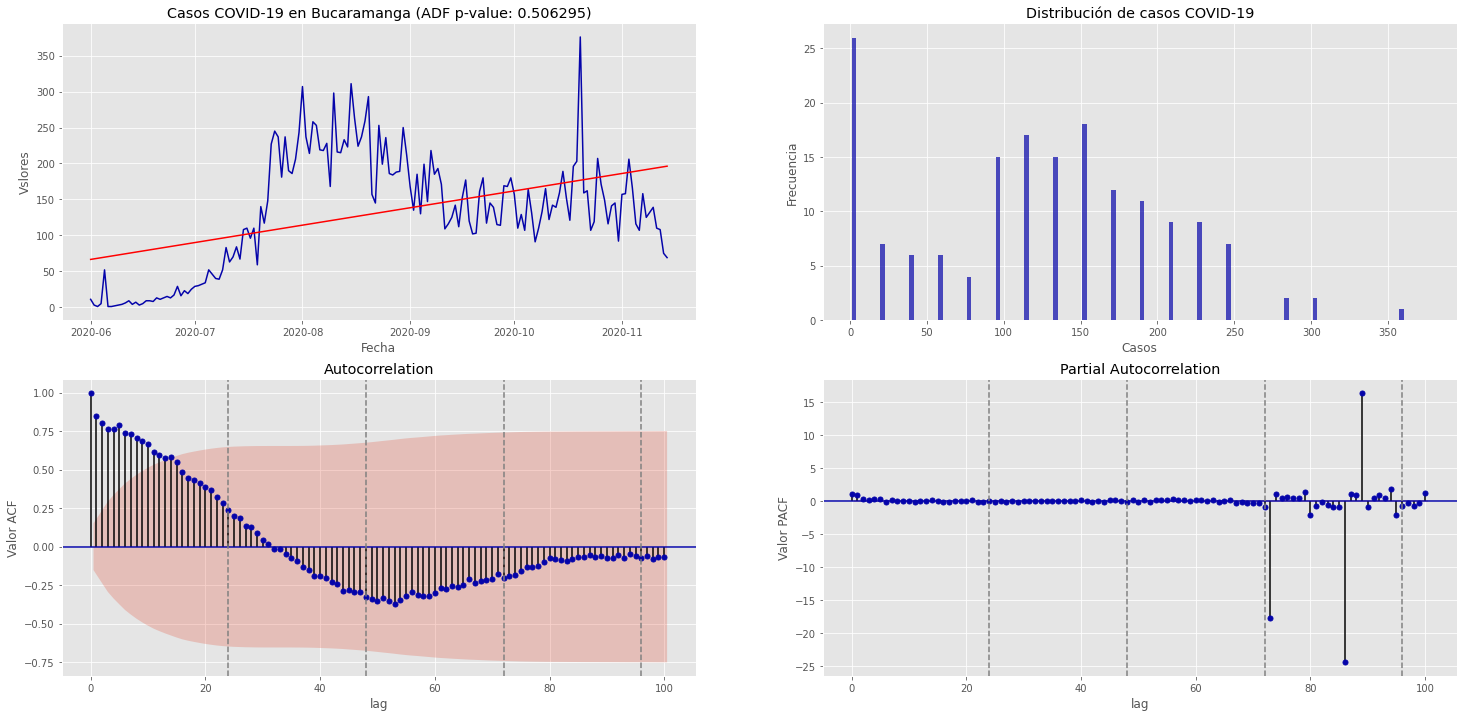

Descomposición


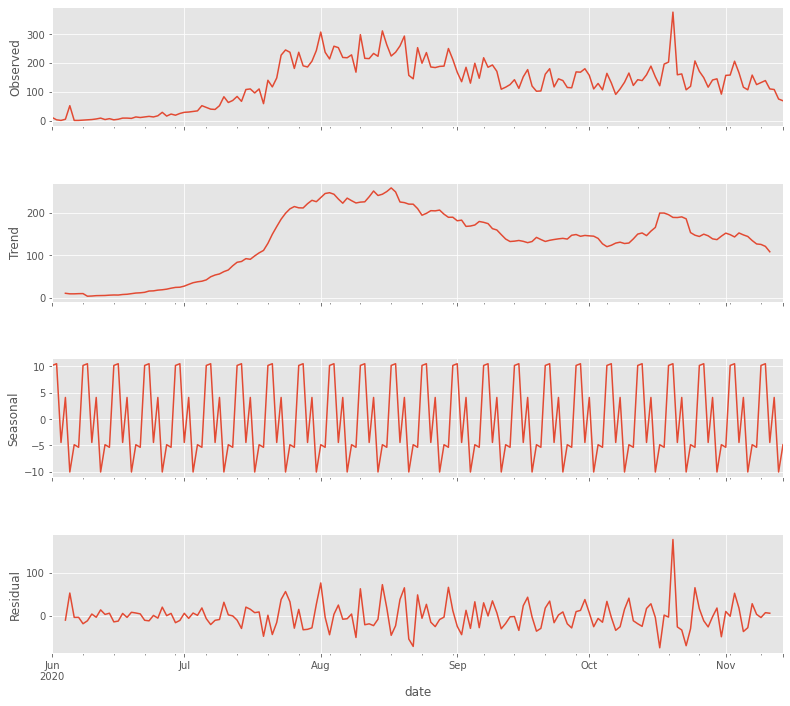

In [16]:
#@title Análisis del comportamiento en Bucaramanga
Fecha_inicial = '2020-06-01' #@param {type:"date"}
Fecha_final = '2020-11-14' #@param {type:"date"}

initial_date = datetime.datetime.strptime(Fecha_inicial, '%Y-%m-%d')
final_date = datetime.datetime.strptime(Fecha_final, '%Y-%m-%d')
serie_bucaramanga = df_join.loc[(df_join.index >= initial_date) & (
    df_join.index <= final_date), 'BUCARAMANGA'].fillna(axis=0,
                                                        method='backfill',
                                                        inplace=False)
print('Análisis de tendencia y autocorrelación')
utils.ts_analysis_plots(serie_bucaramanga)

print('Descomposición')
res = seasonal_decompose(serie_bucaramanga, model='additive')
fig = res.plot()
fig.set_size_inches((12, 12))